# Natural Language Processing for Text Classification 

### Project made by
 # Iliyan Nedelchev 
 
 *In this project I will be using dataset used to classify News descriptions. There are 4 categories: Sports, Business, World, SciTech. This is a manually curated dataset of news description and their classes from AGWeb.com.. I got the dataset from <https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e>  . I will be using Natural Language Processing for the task Text Classification.*

#### What is Natural Language Processing?

*Natural language processing (NLP) is a subfield of linguistics, computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data. Challenges in natural language processing frequently involve speech recognition, natural language understanding, and natural language generation.*

### In this project I will cover:

- Feature Extraction
- Regular Expressions
- Feature Engineering
- A few scikit-learn Classification Algorithms

### For the project I will be using:
- The **nltk** library for the language processing operations such as removing stems and stopwords
- The **pandas** library for the dataframe operations
- The **scikit-learn** library for the algorithms,getting the features and separating the data

In [103]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import json as j
import nltk 

np.random.seed = 42
from sklearn.externals import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer

## 1. Load the dataset

In [104]:
json_data = None
with open('text_data/News Classification DataSet.json') as data_file:
    lines = data_file.readlines()
    joined_lines = "[" + ",".join(lines) + "]"

    json_data = j.loads(joined_lines)

data = pd.DataFrame(json_data)

In [105]:
data.head()

,annotation,content,extras,metadata
0,"{'notes': '', 'label': ['Business']}",Unions representing workers at Turner Newall...,None,"{'first_done_at': 1521027375000, 'last_updated..."
1,"{'notes': '', 'label': ['SciTech']}","SPACE.com - TORONTO, Canada -- A second\team o...",None,"{'first_done_at': 1521027375000, 'last_updated..."
2,"{'notes': '', 'label': ['SciTech']}",AP - A company founded by a chemistry research...,None,"{'first_done_at': 1521027375000, 'last_updated..."
3,"{'notes': '', 'label': ['SciTech']}",AP - It's barely dawn when Mike Fitzpatrick st...,None,"{'first_done_at': 1521027375000, 'last_updated..."
4,"{'notes': '', 'label': ['SciTech']}",AP - Southern California's smog-fighting agenc...,None,"{'first_done_at': 1521027375000, 'last_updated..."


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 4 columns):
annotation    7600 non-null object
content       7600 non-null object
extras        0 non-null object
metadata      7600 non-null object
dtypes: object(4)
memory usage: 118.8+ KB


*There are no missing values in the dataset and I can move on*

### Separating features and labels

In [107]:
data_features = data['content']

In [108]:
data_features.head()

0    Unions representing workers at Turner   Newall...
1    SPACE.com - TORONTO, Canada -- A second\team o...
2    AP - A company founded by a chemistry research...
3    AP - It's barely dawn when Mike Fitzpatrick st...
4    AP - Southern California's smog-fighting agenc...
Name: content, dtype: object

In [109]:
data_labels = data['annotation']

In [110]:
data_labels.head()

0    {'notes': '', 'label': ['Business']}
1     {'notes': '', 'label': ['SciTech']}
2     {'notes': '', 'label': ['SciTech']}
3     {'notes': '', 'label': ['SciTech']}
4     {'notes': '', 'label': ['SciTech']}
Name: annotation, dtype: object

## 2. Preprocess the data

*The labels are with rather strange syntax and this can be a problem,so lets replace them with the categories:
__'Business', 'SciTech', 'Sports', 'World'__.*


In [111]:
data_labels_cleaned = data_labels.replace([{'notes': '', 'label': ['Business']}], 'Business')
data_labels_cleaned = data_labels_cleaned.replace([{'notes': '', 'label': ['SciTech']}], 'SciTech')
data_labels_cleaned = data_labels_cleaned.replace([{'notes': '', 'label': ['Sports']}], 'Sports')
data_labels_cleaned = data_labels_cleaned.replace([{'notes': '', 'label': ['World']}], 'World')
data_labels_cleaned.head()

0    Business
1     SciTech
2     SciTech
3     SciTech
4     SciTech
Name: annotation, dtype: object

###  Transforming the labels from categorical to indicator variables:
**Business = 0, SciTech = 1, Sports = 2, World = 3**

In [112]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

data_labels_final = encoder.fit_transform(data_labels_cleaned)

In [113]:
print(data_labels_final)

[0 1 1 ... 2 0 0]


__Lets see all the classes__

In [114]:
set(data_labels_final)

{0, 1, 2, 3}

*Now it's looking better!*
#### Lets see how many instances there are in each class

In [115]:
data_labels_cleaned.value_counts()

World       1900
Business    1900
Sports      1900
SciTech     1900
Name: annotation, dtype: int64

*The data is equaly destributed*

## 2.1 Regular Expressions

*Some common regular expression metacharacters - copied from wikipedia*

**^** Matches the starting position within the string. In line-based tools, it matches the starting position of any line.

**.** Matches any single character (many applications exclude newlines, and exactly which characters are considered newlines is flavor-, character-encoding-, and platform-specific, but it is safe to assume that the line feed character is included). Within POSIX bracket expressions, the dot character matches a literal dot. For example, a.c matches "abc", etc., but [a.c] matches only "a", ".", or "c".

**[ ]** A bracket expression. Matches a single character that is contained within the brackets. For example, [abc] matches "a", "b", or "c". [a-z] specifies a range which matches any lowercase letter from "a" to "z". These forms can be mixed: [abcx-z] matches "a", "b", "c", "x", "y", or "z", as does [a-cx-z]. The - character is treated as a literal character if it is the last or the first (after the ^, if present) character within the brackets: [abc-], [-abc]. Note that backslash escapes are not allowed. The ] character can be included in a bracket expression if it is the first (after the ^) character: []abc].

**[^ ]** Matches a single character that is not contained within the brackets. For example, [^abc] matches any character other than "a", "b", or "c". [^a-z] matches any single character that is not a lowercase letter from "a" to "z". Likewise, literal characters and ranges can be mixed.

**$** Matches the ending position of the string or the position just before a string-ending newline. In line-based tools, it matches the ending position of any line.

**( )** Defines a marked subexpression. The string matched within the parentheses can be recalled later (see the next entry, \n). A marked subexpression is also called a block or capturing group. BRE mode requires ( ).

**\n** Matches what the nth marked subexpression matched, where n is a digit from 1 to 9. This construct is vaguely defined in the POSIX.2 standard. Some tools allow referencing more than nine capturing groups.

__*__  Matches the preceding element zero or more times. For example, abc matches "ac", "abc", "abbbc", etc. [xyz] matches "", "x", "y", "z", "zx", "zyx", "xyzzy", and so on. (ab)* matches "", "ab", "abab", "ababab", and so on.

**{m,n}** Matches the preceding element at least m and not more than n times. For example, a{3,5} matches only "aaa", "aaaa", and "aaaaa". This is not found in a few older instances of regexes. BRE mode requires {m,n}

**?** Matches the preceding element zero or one time. For example, ab?c matches only "ac" or "abc".

**+** Matches the preceding element one or more times. For example, ab+c matches "abc", "abbc", "abbbc", and so on, but not "ac".

**|** The choice (also known as alternation or set union) operator matches either the expression before or the expression after the operator. For example, abc|def matches "abc" or "def".

In [116]:
# Replacing money symbols ($,€,£ etc. ) with 'moneysymbol'
data_features_processed = data_features.str.replace(r'£|\$|\€', 'moneysymbol')

In [117]:
# Replacing numbers (1,2,6,10 etc.) with 'number'
data_features_processed = data_features_processed.str.replace(r'\d+(\.\d+)?', 'number')

In [118]:
# Removing punctuation
data_features_processed = data_features_processed.str.replace(r'[^\w\d\s]', ' ')

In [119]:
# Removing whitespace with a single space ' '
data_features_processed = data_features_processed.str.replace(r'\s+', ' ')

In [120]:
# Removing leading and trailing whitespace
data_features_processed = data_features_processed.str.replace(r'^\s+|\s+?$', '')

*Since words like 'People', 'people' and 'PEOPLE' are  __3 different words__ they need to be made the same*

In [121]:
# Changing words to lower case
data_features_processed = data_features_processed.str.lower()

#### Lets see the data so far

In [122]:
# Printing the 1st 10 instances of the data
print(data_features_processed[0:10])

0    unions representing workers at turner newall s...
1    space com toronto canada a second team of rock...
2    ap a company founded by a chemistry researcher...
3    ap it s barely dawn when mike fitzpatrick star...
4    ap southern california s smog fighting agency ...
5    the british department for education and skill...
6    sven jaschan self confessed author of the nets...
7    foaf loaf and bloom filters have a lot of inte...
8    wiltshire police warns about phishing after it...
9    in its first two years the uk s dedicated card...
Name: content, dtype: object


### Removing stopwords and stems

In [123]:
from nltk.corpus import stopwords

# Removing the stopwords
stop_words = set(stopwords.words('english'))

data_features_processed = data_features_processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [124]:
# Removing word stems 
ps = nltk.PorterStemmer()

data_features_processed = data_features_processed.apply(lambda x: ' '.join(
    ps.stem(term) for term in x.split()))

#### Lets see the result after removing the stopwords and the stems

In [125]:
# Printing the 1st 10 instances of the data 
print(data_features_processed[:10])

0    union repres worker turner newal say disappoin...
1    space com toronto canada second team rocket co...
2    ap compani found chemistri research univers lo...
3    ap bare dawn mike fitzpatrick start shift blur...
4    ap southern california smog fight agenc went e...
5    british depart educ skill dfe recent launch mu...
6    sven jaschan self confess author netski sasser...
7    foaf loaf bloom filter lot interest properti s...
8    wiltshir polic warn phish fraud squad chief ta...
9    first two year uk dedic card fraud unit recov ...
Name: content, dtype: object


## 4. Splitting the data to training and testing sets

In [126]:
features_train,features_test,labels_train,labels_test = train_test_split(
 data_features_processed, data_labels_final, train_size = 0.7, stratify = data_labels_final, random_state = 42)

#### Lets check the shape of the training and testing sets

In [127]:
features_train.shape

(5320,)

In [128]:
features_test.shape

(2280,)

In [129]:
labels_train.shape

(5320,)

In [130]:
labels_test.shape

(2280,)

*Everything looks fine and I can move on to modeling*

## 4. Generating features

*Feature engineering is the process of using domain knowledge of the data to create features for machine learning algorithms. In this project, the words in each news report will be my features. I need to transform them into numbers or vectors that will represent them.*

*In text procesing, words of the text represent discrete,categorical features. How do we encode such data in a way which is ready to be used by the algorithms? The mapping from textual data to real valued vectors is called __feature extraction__.*



>### For the feature extraction I can be using the BOW (Bag of Words) method with TF-IDF representation of the text, the Word Embedding method and etc. using scikit-learn's library


>>What is **TF-IDF**? 
>>>*TF-IDF is a score that represents the relative importance of a term in the document and the entire corpus. TF stands for Term Frequency, and IDF stands for Inverse Document Frequency:*

![alt text](text_data/TF-IDF.png "Logo Title Text 1")
   
   
>>>*The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.*

>>> *One of the major disadvantages of using BOW is that it discards word order thereby ignoring the context and in turn meaning of word in the document. For Natural Language Processing maintaining the context of the words is of utmost importance. Using the Word Embedding approach we can solve this problem.*

>> What are **Word Embeddings** ?
>>>*This is a representation of text where words that have the same meaning have a similar representation. In other words it represents words in a coordinate system where related words,based on a corpus of relationships,are placed closer together.*

#### Lets try with the BOW method using TF-IDF text representation 

*__1. Training set__*

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here
vectorizer = TfidfVectorizer(use_idf=True)
 
# Transforming the testing set
data_features_train_final = vectorizer.fit_transform(features_train)

#### Creating a pandas dataframe with each word and it's TF-IDF score

In [132]:
# getting the first vector out (for the first document)
first_vector=data_features_train_final[0]
 
# placing tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
hunt,0.788353
lobbi,0.306263
pro,0.235991
illeg,0.220780
ban,0.217544
britain,0.196895
support,0.194095
continu,0.188145
say,0.145266
pisanu,0.000000


*__2. Testing set__*

In [133]:
data_features_test_final = vectorizer.transform(features_test)

In [134]:
test_first_vector=data_features_test_final[0]
 
df = pd.DataFrame(test_first_vector.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
countri,0.328583
recogn,0.292013
dump,0.277561
penalti,0.267308
statu,0.263110
argentina,0.259355
grant,0.252857
impos,0.236478
worldwid,0.232911
asian,0.229669


*__3. Shapes__*

In [135]:
data_features_train_final.shape

(5320, 11814)

In [136]:
data_features_test_final.shape

(2280, 11814)

*Everything looks good so I can move on to modeling*

## 5. Modeling

In [137]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline

*I coud be using the __SelectKBest__ algorithm to select only the best features after the TF-IDF, but my dataset is relatively small - 5320 features for training the model, so I don't need to use it here*

*Lets try a few classyfiers. I will be using __K Nearest Neighbors, Naive Bayes__ , __SVC__ and __Decision Tree__*

In [138]:
labels_test.shape

(2280,)

In [139]:
joblib.dump(labels_test, "labels_test.pkl")

['labels_test.pkl']

In [140]:
data_features_test_final.shape

(2280, 11814)

In [141]:
joblib.dump(data_features_test_final, "features_test.pkl")

['features_test.pkl']

In [142]:
labels_train.shape

(5320,)

In [143]:
joblib.dump(labels_train, "labels_train.pkl")

['labels_train.pkl']

In [144]:
data_features_train_final.shape

(5320, 11814)

In [145]:
joblib.dump(data_features_train_final, "features_train.pkl")

['features_train.pkl']

In [146]:
names = ["K Nearest Neighbors","Naive Bayes",
          "SVC","Decision Tree"]

classifiers = [
    KNeighborsClassifier(),
    MultinomialNB(),
    SVC(gamma='auto'),
    DecisionTreeClassifier()
]

models = zip(names, classifiers)

for name, model in models:
    model.fit(data_features_train_final,labels_train)
    accuracy = model.score(data_features_train_final,labels_train)*100
    print("{} Training Accuracy: {}".format(name, accuracy))
    accuracy_test = model.score(data_features_test_final, labels_test)*100
    print("{} Testing Accuracy: {}".format(name, accuracy_test))

K Nearest Neighbors Training Accuracy: 89.09774436090225
K Nearest Neighbors Testing Accuracy: 83.99122807017544
Naive Bayes Training Accuracy: 92.59398496240601
Naive Bayes Testing Accuracy: 87.10526315789474
SVC Training Accuracy: 80.65789473684211
SVC Testing Accuracy: 77.98245614035088
Decision Tree Training Accuracy: 100.0
Decision Tree Testing Accuracy: 67.23684210526316


*The models are doing better on the data they know (the __training data__) compared to the data thats new for them (the __testing data__). We can say that the models have __high variance__.*

*The __SVC__'s score is pretty low compared to the K Nearest Neighbors and Naive Bayes models. The Decision Tree seems to have __high variance__ but also __high bias for the testing set__.  The scores for __K Nearest Neighbors__ and __Naive Byes__ are not that bad, I can fine-tune them to try improve their performance. I can try to boost the Decision Tree by using __Random Forest model__ that is relying on multyple trees. Since the results are not bad and  __TF-IDF__ is much faster way to represent the text data than __Word2Vec__ (it takes much less time to do TF-IDF transformation than train Word2Vec model), I will stick with that method.*

## 6. Fine-Tuning the models

*I am dealing with a multyclass classification wich is a problem for scikit-learn's __GridSearchCV__. So I will have to tune the models on hand.*

### K Nearest Neighbours

*I will tune the __n_neighbors__ parameter (the number of neighbours to use)*

*I can use __AUC (Area Under Curve)__ as the evaluation metric, but It's not working for multyclass problems like this one,
so I will be using __Accuracy__ for evaluating the K Nearest Neighbors model's performance.* 

### Lets tune the "n_neighbors" parameter

*I will create a __validation set__ from the training set. I will train the algorithm with the new training set and test with the validation set. The size for validating that I chose is __15%__. The dataset is small - only 7600 documents in total and 5320 for training. After using __TF-IDF__ transformation to the text I have __11814__ features which is still small amount but they wil do the job.*

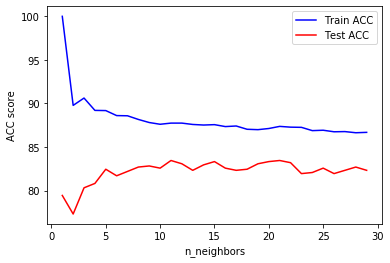

In [147]:
#Creating a validation set from the whole training set
features_training_set,features_validation_set, labels_training_set, labels_validation_set = train_test_split(
 data_features_train_final, labels_train, train_size = 0.85 , stratify = labels_train,random_state = 42)

neighbors = list(range(1,30))
train_results = []
test_results = []

for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(features_training_set, labels_training_set)
    
    train_accuracy = model.score(features_training_set,labels_training_set)*100   
    test_accuracy = model.score(features_validation_set,labels_validation_set)*100
    
    train_results.append(train_accuracy)
   
    test_results.append(test_accuracy)  
             
line1 = plt.plot(neighbors, train_results, 'b', label= "Train ACC")
line2 = plt.plot(neighbors, test_results, 'r', label= "Test ACC")

plt.ylabel('ACC score')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()

*The graph shows that the accuracy for the data that the model knows (training set) is higher the less neighbors the models has. The accuracy for the data that's new for the model (testing set) is higher the more neighbors the models has. Also the algorithm performs better on the training data compared to the testing data.*

*Creating a pandas DataFrame with each __n_neighbors value__ (1:29) as a column and  __the scores__ 
as rows (index: __0 - training, 1 - testing__).*

In [148]:
table = pd.DataFrame(data = [train_results,test_results] , columns = neighbors)

In [149]:
print(table)

           1          2          3          4          5          6   \
0  100.000000  89.783282  90.623618  89.208315  89.186201  88.611234   
1   79.448622  77.318296  80.325815  80.827068  82.456140  81.704261   

          7          8          9          10  ...         20         21  \
0  88.589120  88.168952  87.815126  87.616099  ...  87.129589  87.372844   
1  82.205514  82.706767  82.832080  82.581454  ...  83.333333  83.458647   

          22         23         24         25         26         27  \
0  87.284387  87.262273  86.886333  86.930562  86.753649  86.775763   
1  83.208020  81.954887  82.080201  82.581454  81.954887  82.330827   

          28         29  
0  86.643078  86.687307  
1  82.706767  82.330827  

[2 rows x 29 columns]


#### Lets see all values

In [150]:
table.values

array([[100.        ,  89.78328173,  90.62361787,  89.2083149 ,
         89.1862008 ,  88.61123397,  88.58911986,  88.16895179,
         87.81512605,  87.61609907,  87.74878372,  87.74878372,
         87.59398496,  87.52764264,  87.57187085,  87.35072977,
         87.41707209,  87.04113224,  86.99690402,  87.12958868,
         87.37284387,  87.28438744,  87.26227333,  86.88633348,
         86.9305617 ,  86.75364883,  86.77576294,  86.64307828,
         86.6873065 ],
       [ 79.44862155,  77.31829574,  80.32581454,  80.82706767,
         82.45614035,  81.70426065,  82.20551378,  82.70676692,
         82.8320802 ,  82.58145363,  83.45864662,  83.08270677,
         82.33082707,  82.95739348,  83.33333333,  82.58145363,
         82.33082707,  82.45614035,  83.08270677,  83.33333333,
         83.45864662,  83.20802005,  81.95488722,  82.0802005 ,
         82.58145363,  81.95488722,  82.33082707,  82.70676692,
         82.33082707]])

*So for the __n_neighbors__ parameter I will get __21__, because the test accuracy is highest and the train accuracy is close to the test one (that's the lowest variance in the results).*

### Lets see how the model will perform with the parameter value I chose: "n_neighbors = 21" 

In [202]:
finalKN_model = KNeighborsClassifier(n_neighbors = 1)
finalKN_model.fit(data_features_train_final, labels_train)  

train_accuracy = finalKN_model.score(data_features_train_final,labels_train)*100   
test_accuracy = finalKN_model.score(data_features_test_final,labels_test)*100

In [203]:
print(train_accuracy)
print(test_accuracy)

100.0
79.82456140350878


In [204]:
joblib.dump(finalKN_model, "KN_model.pkl")

['KN_model.pkl']

### Lets try improving the performance of Decision Tree

*For the Decision Tree I will tune the __max_depth__ , __max_leaf_nodes__ and the __min_samples_leaf__ parameters.*

### Tuning the "max_depth" parameter

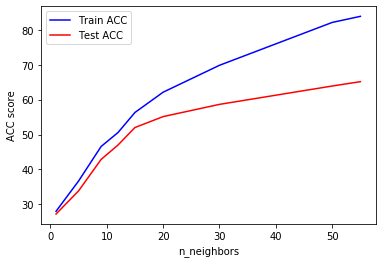

In [154]:
depths = [1,5,9,12,15,20,30,50,55]
train_results = []
test_results = []

for d in depths:
    model = DecisionTreeClassifier(max_depth = d)
    model.fit(features_training_set, labels_training_set)
    
    train_accuracy = model.score(features_training_set,labels_training_set)*100   
    test_accuracy = model.score(features_validation_set,labels_validation_set)*100
    
    train_results.append(train_accuracy)
   
    test_results.append(test_accuracy)  
             
line1 = plt.plot(depths, train_results, 'b', label= "Train ACC")
line2 = plt.plot(depths, test_results, 'r', label= "Test ACC")

plt.ylabel('ACC score')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()

In [155]:
table = pd.DataFrame(data = [train_results,test_results] , columns = depths)

In [156]:
print(table)

          1          5          9          12         15         20  \
0  27.974348  36.665192  46.572313  50.574967  56.324635  62.140646   
1  27.192982  33.834586  42.857143  46.992481  52.005013  55.137845   

          30         50         55  
0  69.858470  82.153914  83.900929  
1  58.646617  63.909774  65.162907  


*From the graph and the table we can see that the results on the testing set are alot worse than those on the training set.Also the more depth it has,the better results. Reaching around "max_depth = 50" the results are getting worse.So I can take __"48"__ for the __"max_depth"__ parameter*

### Tuning the "max_leaf_nodes" parameter

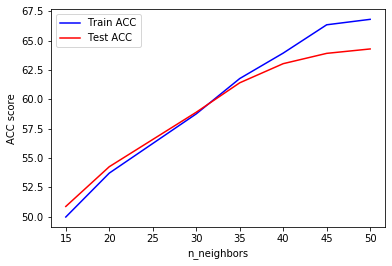

In [157]:
nodes = [15,20,30,35,40,45,50,None]
train_results = []
test_results = []

for n in nodes:
    model = DecisionTreeClassifier(max_leaf_nodes = n)
    model.fit(features_training_set, labels_training_set)
    
    train_accuracy = model.score(features_training_set,labels_training_set)*100   
    test_accuracy = model.score(features_validation_set,labels_validation_set)*100
    
    train_results.append(train_accuracy)
   
    test_results.append(test_accuracy)  
             
line1 = plt.plot(nodes, train_results, 'b', label= "Train ACC")
line2 = plt.plot(nodes, test_results, 'r', label= "Test ACC")

plt.ylabel('ACC score')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()

In [158]:
table = pd.DataFrame(data = [train_results,test_results] , columns = nodes)

In [159]:
print(table)

          15         20         30         35         40         45  \
0  49.977886  53.715170  58.757187  61.764706  63.931889  66.342326   
1  50.877193  54.260652  58.897243  61.403509  63.032581  63.909774   

          50         NaN  
0  66.806723  100.000000  
1  64.285714   69.172932  


*This time the results on the two sets are very close to each other. The default value is "None" and we can see that in that case we have a __high variance__. Since the results on the testing set are not improving much with the default value,its better to consider the much less variance we got with the value of __"50"__.*

### Tuning the "min_samples_leaf" parameter

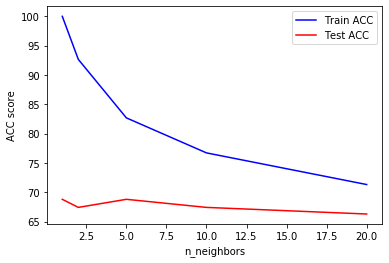

In [160]:
leafs = [1,2,5,10,20]
train_results = []
test_results = []

for l in leafs:
    model = DecisionTreeClassifier(min_samples_leaf = l)
    model.fit(features_training_set, labels_training_set)
    
    train_accuracy = model.score(features_training_set,labels_training_set)*100   
    test_accuracy = model.score(features_validation_set,labels_validation_set)*100
    
    train_results.append(train_accuracy)
   
    test_results.append(test_accuracy)  
             
line1 = plt.plot(leafs, train_results, 'b', label= "Train ACC")
line2 = plt.plot(leafs, test_results, 'r', label= "Test ACC")

plt.ylabel('ACC score')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()

In [161]:
table = pd.DataFrame(data = [train_results,test_results] , columns = leafs)

In [162]:
print(table)

           1          2          5          10         20
0  100.000000  92.658116  82.684653  76.713843  71.318001
1   68.796992  67.418546  68.796992  67.418546  66.290727


*From the graph we can see that the more samples per leaf the tree has,the worse the accuracy is. Even though the more samples the closer the results on the two set are meaning __less variance__. With that being said I will get __"20"__ as 
the value for the parameter.*

In [205]:
finalTree_model = DecisionTreeClassifier(max_depth = 48, min_samples_leaf = 20, max_leaf_nodes = 50)
finalTree_model.fit(data_features_train_final, labels_train)  

train_accuracy = finalTree_model.score(data_features_train_final,labels_train)*100   
test_accuracy = finalTree_model.score(data_features_test_final,labels_test)*100

In [206]:
print(train_accuracy)
print(test_accuracy)

67.31203007518796
63.1140350877193


*The fine-tuning didn't improve much when it comes to the results on the testing set,but now the performances on the two sets are alot closer.I made __more stable model with less variance__. Improving __the bias__ may need more data to train the model.Or I can try combining some of these fine-tuned trees using __Random Forest__.*

*Lets save the tuned tree model*

In [207]:
joblib.dump(finalTree_model, "DecisionTree_model.pkl")

['DecisionTree_model.pkl']

## Combining trees with Random Forest

*For the Random Forest model I will be tuning the __n_estimators__ parameter. The  __max_depth__, __min_samles_leaf__ and __max_leaf_nodes__ parameters I will take from the tuned DecisionTree model.*

### Tuning the "n_estimators" parameter

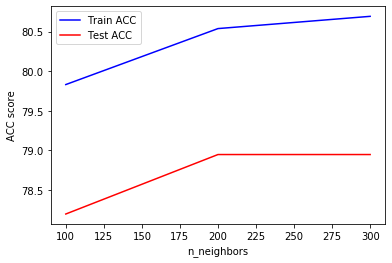

In [167]:
from sklearn.ensemble import RandomForestClassifier
estimators = [100,200,300]
train_results = []
test_results = []

for e in estimators:
    model = RandomForestClassifier(n_estimators = e, max_depth = 48, min_samples_leaf = 20, max_leaf_nodes = 50)
    model.fit(features_training_set, labels_training_set)
    
    train_accuracy = model.score(features_training_set,labels_training_set)*100   
    test_accuracy = model.score(features_validation_set,labels_validation_set)*100
    
    train_results.append(train_accuracy)
   
    test_results.append(test_accuracy)  
             
line1 = plt.plot(estimators, train_results, 'b', label= "Train ACC")
line2 = plt.plot(estimators, test_results, 'r', label= "Test ACC")

plt.ylabel('ACC score')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()

In [170]:
table = pd.DataFrame(data = [train_results,test_results] , columns = estimators)

In [171]:
print(table)

         100        200        300
0  79.831933  80.539584  80.694383
1  78.195489  78.947368  78.947368


*The scores are __improved__ with 13%. The __variance__ is improved aswell and now it's less than 2%. For the __n_estimators__ parameter I will choose __200__.* 

In [194]:
finalForest_model = RandomForestClassifier(n_estimators = 200, max_depth = 48, min_samples_leaf = 20, max_leaf_nodes = 50)
finalForest_model.fit(data_features_train_final, labels_train)  

train_accuracy = finalForest_model.score(data_features_train_final,labels_train)*100   
test_accuracy = finalForest_model.score(data_features_test_final,labels_test)*100

In [195]:
print(train_accuracy)
print(test_accuracy)

81.05263157894737
78.85964912280701


*The scores on the testing set are slightly better than those on the validation set.*

In [196]:
joblib.dump(finalForest_model, "Forest_model.pkl")

['Forest_model.pkl']

### Now before comparing the models lets save the Naive Bayes Classifier

In [197]:
finalNB_model = MultinomialNB()
finalNB_model.fit(data_features_train_final, labels_train)

train_accuracy = finalNB_model.score(data_features_train_final,labels_train)*100   
test_accuracy = finalNB_model.score(data_features_test_final,labels_test)*100

In [198]:
print(train_accuracy)
print(test_accuracy)

92.59398496240601
87.10526315789474


In [199]:
joblib.dump(finalNB_model, "NaiveBayes_model.pkl")

['NaiveBayes_model.pkl']

## 7. Comparing the final models

In [200]:
def compare():
    K_Nearest_best = joblib.load("KN_model.pkl")
    DecisionTree_best = joblib.load("DecisionTree_model.pkl")
    Forest_best = joblib.load("Forest_model.pkl")
    
    names = ["KN_model.pkl","DecisionTree_model.pkl", "Forest_model.pkl","NaiveBayes_model.pkl"]
                
    classifiers = [
        "K Neighbors Classifier",
        "Decision Tree Classifier",
        "Random Forest Classifier",
        "Naive Bayes Classifier"
    ]
    models = zip(names, classifiers)

    for name, classifier in models:
        model = joblib.load(name)
        accuracy = model.score(data_features_train_final,labels_train)*100
        print("{} Training Accuracy: {}".format(classifier, accuracy))
        accuracy_test = model.score(data_features_test_final, labels_test)*100
        print("{} Testing Accuracy: {}".format(classifier, accuracy_test))

In [201]:
compare()

K Neighbors Classifier Training Accuracy: 100.0
K Neighbors Classifier Testing Accuracy: 79.82456140350878
Decision Tree Classifier Training Accuracy: 67.31203007518796
Decision Tree Classifier Testing Accuracy: 63.1140350877193
Random Forest Classifier Training Accuracy: 81.05263157894737
Random Forest Classifier Testing Accuracy: 78.85964912280701
Naive Bayes Classifier Training Accuracy: 92.59398496240601
Naive Bayes Classifier Testing Accuracy: 87.10526315789474


*__K Nearest Neighbors__ and __Random Forest__ have close scores but the Random Forest is __more stable__ (it has less variance).K Nearest Neighbors has the __highest variance__ (It's expressing the training data very well to the point that it's overfiting the data but it fails to perform well on new data). The Naive Bayes Classifier has __the lowest baias__ and highest variance after the K Nearest Neighbors.*

## 8. Conclusion

*For this project of Natural Language Processing for Text Classification I used my knowedge in Data Science for dealing with the text data(preparing the text for the later use in Machine learning algorithms). I used transformations such as regular expressions,removing stopwords from the text ("a","too","this","than","that","the" and many more), removing stems, white spaces and more.I separated the data into training and testing set and then used the Bag of Words method with TF-IDF to create a numerical representation of the text. For the Machine learning part I decided to use 5 classifying model: K Nearest Neighbors,Naive Bayes, Decision Tree, Support Vector Machines and Random Forest. I worked on improving the performance on 3 of these models (K Nearest Neighbors,Decission Trees and Random Forest) by fine-tuning some of their parameters. Naive Bayes Classifier gave the best results even after working on the other algorithms. Tuning it didn't give any change in the performance and that's why I didn't include it in the tuned algorithms. For the Decission Tree model (and the others)I was aiming for the lowest variance possible given the fact that the accuracy scores were close. Beacause it's a 4 class classification problem (multyvariate) I couldn't use scikit-learns GridSearchCV to fine-tune the different models' parameters. That's why I did it manualy for each parameter (I didn't use parameter combinations). I did validation by separating the training set into a smaller training set and a validation set to measure the models' performace with each parameter value and after deciding which values are best to use, I evaluated the models on the testing set. At the end I compared the best models of each type.*

## 9. How to improve the project 
### (Making the project better)

#### 1. Using Word Embeddings for the text representation instead of the TF-IDF 
*Word Embeddings can capture the context of each word in the dataset wich is expected to improve the performance. I didn't use this method to represent the text in my project because it's time consuming. Training a Word2Vec model takes much more time than using TF-IDF transformation*

#### 2. Clustering the word features to try finding structure in the data and then adding the clusters to the features
*By doing this you can make the models have better results*

#### 3. Using Ensemble methods
*Another way to fine-tune your system is to try to combine the models that perform best.The group (or "ensemble") will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on).*

#### 4. Using cross-validation 
*This is good when you have a small dataset and only one __validation set__ is not going to help so instead you can use cross-validation wich randomly splits the training set into a number of folds. Then it trains and evaluates the model k-times, picking a different fold for evaluation every time and training on the other k-1 folds.*